# 1. Extract data

In [14]:
import re
import ast
import pandas as pd
import os

def is_blacklist(name):
    """
    Check if the given node name is in the blacklist.

    Parameters
    ----------
    name : str
        The name of the node.

    Returns
    ------
    bool
        True if the node is in the blacklist, False otherwise.
    """
    return (name == 'main') or (re.search(r'test', name, re.IGNORECASE)) or (name[0] == '_')

def get_comment_from_item(item):
    """
    Check if the given node name is in the blacklist.

    Parameters
    ----------
    name : item
        The item attribute of the node.

    Returns
    ------
    str
        String containing the comment of the node.
    """
    comment = ''
    for item_comment in item.body:
        if isinstance(item_comment, ast.Expr) and isinstance(item_comment.value, ast.Str):
            comment = item_comment.value.s
            break
    return comment.replace('\n', ' ').strip()

def extract_info_from_node(node, data, file_path):
    """
    Check if the given node name is in the blacklist.

    Parameters
    ----------
    name : node
        The AST node.
    name : data
        A dictionary with keys 'functions', 'classes', and 'methods'.

    Returns
    ------
    pandas dataframe
        pandas dataframe containing all the organized information.
    """
    for item in node.body:
        is_func = isinstance(item, ast.FunctionDef)
        is_class = isinstance(item, ast.ClassDef)
        if (is_func or  is_class) and not(is_blacklist(item.name)):
            comment = get_comment_from_item(item)
            if is_func:
                data['functions'].append((item.name, file_path, item.lineno, comment)) 
            elif is_class:
                data['classes'].append((item.name, file_path, item.lineno, comment))
                for class_item in item.body:
                    if isinstance(class_item, ast.FunctionDef) and not(is_blacklist(class_item.name)):
                        class_comment = get_comment_from_item(class_item)
                        data['methods'].append((class_item.name, file_path, class_item.lineno, class_comment))

    return data


def extract_info_from_file(dir_path):
    """
    Extract information from a given file.

    Parameters
    ----------
    file_path : str
        The file path.

    Returns
    ------
    pandas dataframe
        pandas dataframe containing all the organized information.
    """
    file_paths = []
    for root, dirs, files in os.walk(dir_path):
        for file in files:
            if file.endswith('.py'):
                file_paths.append(os.dir_path.join(root, file))

    data = {'functions': [], 'classes': [], 'methods': []}
    for file_path in file_paths:
        with open(file_path) as f:
            node = ast.parse(f.read())
            data = extract_info_from_node(node, data, file_path)

    df = pd.DataFrame(columns=['name', 'file', 'type', 'line', 'comment'])
    for key, value in data.items():
        for item in value:
                df.loc[len(df)] = [item[0], item[1], key, item[2], item[3]]

In [16]:
import os

path = './testers/'
file_paths = []
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('.py'):
            file_paths.append(os.path.join(root, file))

data = {'functions': [], 'classes': [], 'methods': []}
for file_path in file_paths:
    with open(file_path) as f:
        node = ast.parse(f.read())
        data = extract_info_from_node(node, data, file_path)

df = pd.DataFrame(columns=['name', 'file', 'type', 'line', 'comment'])
for key, value in data.items():
    for item in value:
            df.loc[len(df)] = [item[0], item[1], key, item[2], item[3]]
print(df)

                             name  \
0                       transform   
1              list_local_devices   
2        get_tpu_cluster_resolver   
3                get_tpu_strategy   
4                BreakTransformer   
5     CollectiveAllReduceStrategy   
6   CollectiveAllReduceStrategyV1   
7     CollectiveAllReduceExtended   
8                     visit_Break   
9                     visit_While   
10                      visit_For   
11               cluster_resolver   
12     experimental_between_graph   
13       experimental_should_init   
14              should_checkpoint   
15            should_save_summary   

                                           file       type  line  \
0                 ./testers/break_statements.py  functions   183   
1                       ./testers/device_lib.py  functions    25   
2                ./testers/tpu_strategy_test.py  functions    70   
3                ./testers/tpu_strategy_test.py  functions    79   
4                 ./testers/br

# 2. train search engines

### Code

In [101]:
import pandas as pd
import re
import pickle
import numpy as np
import sys
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import gensim as gs
from nltk.tokenize import word_tokenize

EXTRA_STOP_WORDS = ['value', "'", 'of', 'graph', 'shape', 'call', 'input', 'tests', 'size', 'name', 'type', '>>>', 'this', 'output', 'test', 'to', 'self', 'returns', 'main', 'get', 'tf', 'args', 'the', 'if', '', 'def', 'variable', 'config', 'compute']
STOP_WORDS = set(stopwords.words('english')).union(EXTRA_STOP_WORDS)
AFTER_FILTERS = ['Args:', 'Returns:', 'Returns', 'Args', 'Also see', 'Also see:', 'Example usage:', '>>>']
PS = PorterStemmer()
SAVE_PATH = './generated_files'
CHECK_FILES = ['/bag_of_words', '/corpus_bow_fv', '/tfidf', '/tfidf_corpus', '/lsi', '/lsi_corpus', '/d2v']

def split_camel_case_underscore_clean(sample):
    sample1 = re.sub('([a-z])([A-Z])', r'\1 \2', sample)
    sample1 = re.sub('_', ' ', sample1)
    sample1 = re.sub(r'\d+', '', sample1)
    sample1 = re.sub(r'[^\w\s]',' ',sample1)
    return sample1

def remove_everything_after(sentence, clauses):
    for clause in clauses:
        if clause in sentence:
            sentence = sentence.split(clause)[0]
    return sentence

def create_entity(name,file,comment):
    name1 = split_camel_case_underscore_clean(name).split(' ')
    file1 = split_camel_case_underscore_clean(file.split('/')[-1].strip('.py')).split(' ')

    pre_final=''
    if comment is not None:
        pre_final=comment
        pre_final = remove_everything_after(pre_final, AFTER_FILTERS)
        pre_final = split_camel_case_underscore_clean(pre_final)
        
    pre_final = pre_final.split(' ')

    final = []
    for pre_w in pre_final+name1+file1:
        w = PS.stem(pre_w.lower())
        if w not in STOP_WORDS:
            final.append(w)

    return final

def get_corpus_processed(df, save_path=SAVE_PATH+'/'):
    corpus = []
    for i in range(len(df)):
        row = df.iloc[i]
        comment = row['comment']
        corpus.append(create_entity(row['name'], row['file'], comment if isinstance(comment, str) else ''))
    if save_path is not None:
        with open(save_path+"corpus_processed", 'wb') as f:
            pickle.dump(corpus, f)
    return corpus

def get_corpus_lower_stemmed(df, save_path=SAVE_PATH+'/'):
    corpus = []
    for i in range(len(df)):
        row = df.iloc[i]
        comment = ''
        if isinstance(row['comment'], str):
            comment = ' '.join([PS.stem(w.lower()) for w in row['comment'].split(' ')])
        corpus.append(comment)
    if save_path is not None:
        with open(save_path+"corpus_lower_stemmed", 'wb') as f:
            pickle.dump(corpus, f)
    return corpus

def query_pipeline(query):
    query1 = split_camel_case_underscore_clean(query)
    query1 = query1.split(' ')
    final = []
    for pre_w in query1:
        w = PS.stem(pre_w.lower())
        if w not in STOP_WORDS:
            final.append(w)
    return final

def get_bag_of_words(processed_sentences, save_path=SAVE_PATH+'/'):
    bag_of_words = gs.corpora.Dictionary(processed_sentences)
    if save_path is not None:
        with open(save_path+"bag_of_words", 'wb') as f:
            pickle.dump(bag_of_words, f)
    return bag_of_words

def get_corpus_fv(corpus, bag_of_words, save_path=SAVE_PATH+'/'):
    corpus_bow_fv = [bag_of_words.doc2bow(sentence) for sentence in corpus]
    if save_path is not None:
        with open(save_path+"corpus_bow_fv", 'wb') as f:
            pickle.dump(corpus_bow_fv, f)
    return corpus_bow_fv

def evaluate_query_fv(corpus_bow_fv, query_bow, bag_of_words):
    index = gs.similarities.SparseMatrixSimilarity(corpus_bow_fv, num_features=len(bag_of_words))
    sims = index[query_bow]
    return sims
    
def get_tfidf_model(corpus_bow_fv, save_path=SAVE_PATH+'/'):
    tfidf = gs.models.TfidfModel(corpus_bow_fv)
    tfidf_corpus = tfidf[corpus_bow_fv]
    if save_path is not None:
        with open(save_path+"tfidf", 'wb') as f:
            pickle.dump(tfidf, f)
        with open(save_path+"tfidf_corpus", 'wb') as f:
            pickle.dump(tfidf_corpus, f)
    return tfidf, tfidf_corpus

def evaluate_query_tfidf(tfidf, query_bow, tfidf_corpus, num_features):
    index = gs.similarities.SparseMatrixSimilarity(tfidf_corpus, num_features=num_features)
    return index[tfidf[query_bow]]

def get_lsi_model(tfidf_corpus, bag_of_words, save_path=SAVE_PATH+'/', num_topics=300):
    lsi = gs.models.LsiModel(tfidf_corpus, id2word=bag_of_words, num_topics=num_topics)
    lsi_corpus = lsi[tfidf_corpus]
    if save_path is not None:
        with open(save_path+"lsi", 'wb') as f:
            pickle.dump(lsi, f)
        with open(save_path+"lsi_corpus", 'wb') as f:
            pickle.dump(lsi, f)
    return lsi, lsi_corpus

def evaluate_query_lsi(lsi, lsi_corpus, tfidf, query_bow):
    index = gs.similarities.MatrixSimilarity(lsi_corpus)
    return abs(index[lsi[tfidf[query_bow]]])

def get_d2v_model(corpus_lower_stemmed, save_path=SAVE_PATH+'/', vector_size=300, num_epochs=40):
    dv_docs = [gs.models.doc2vec.TaggedDocument(words=word_tokenize(doc),tags=[i]) for i, doc in enumerate(corpus_lower_stemmed)]
    d2v = gs.models.Doc2Vec(dv_docs, vector_size=vector_size, epochs=num_epochs)
    d2v.build_vocab(dv_docs)
    d2v.train(dv_docs, total_examples=d2v.corpus_count, epochs=d2v.epochs)
    if save_path is not None:
        with open(save_path+"d2v", 'wb') as f:
            pickle.dump(d2v, f)
    return d2v

def d2v_search(d2v, query, topn=5):
    sentence = ' '.join([PS.stem(w.lower()) for w in query.split(' ')])
    tv = d2v.infer_vector([i for i in word_tokenize(sentence)])
    return d2v.dv.most_similar([tv], topn=topn)

def load_models(dir_path=SAVE_PATH):
    df = pd.read_csv(dir_path+'/data.csv')
    bag_of_words = pickle.load(open(dir_path+'/bag_of_words', 'rb'))
    corpus_bow_fv = pickle.load(open(dir_path+'/corpus_bow_fv', 'rb'))
    tfidf = pickle.load(open(dir_path+'/tfidf', 'rb'))
    lsi = pickle.load(open(dir_path+'/lsi', 'rb'))
    lsi_corpus = pickle.load(open(dir_path+'/lsi_corpus', 'rb'))
    tfidf_corpus = pickle.load(open(dir_path+'/tfidf_corpus', 'rb'))
    d2v = pickle.load(open(dir_path+'/d2v', 'rb'))
    
    return df, bag_of_words, corpus_bow_fv, tfidf, tfidf_corpus, lsi, lsi_corpus, d2v

def pick_top_n(df, sims, n=5):
    result = None
    if len(sims[0]) == 1:
        result = np.argsort(sims, axis=0)[::-1][:n]
    elif len(sims[0]) == 2:
        result = [y[0] for y in sorted(sims, key=lambda x: x[1], reverse=True)]
    if result is None:
        print("Error: similarities have 0 or more than 2 values")
        sys.exit(1)
    else:
        return df.iloc[result]
        
def print_results(results, query, algo):
    print(f"Results for query:\n'{query}'\nusing {algo}:")
    for i in range(len(results)):
        print(f"{i+1}. {results.iloc[i]['name']} in {results.iloc[i]['file']} at line {results.iloc[i]['line']}")
    print()

def check_files_exist():
    make_models = False
    if not os.path.exists(SAVE_PATH):
        os.makedirs(SAVE_PATH)
        make_models = True
    else:
        for file in CHECK_FILES:
            if not os.path.exists(SAVE_PATH+file):
                make_models = True
                break
            
    if make_models:
        if not os.path.exists(SAVE_PATH+'/data.csv'):
            print('data.csv file not found in ./generated_files')
            sys.exit(1)
        else:
            df = pd.read_csv(SAVE_PATH+'/data.csv')
            corpus = get_corpus_processed(df, SAVE_PATH)
            bag_of_words = get_bag_of_words(corpus, SAVE_PATH)
            corpus_bow_fv = get_corpus_fv(corpus, bag_of_words, SAVE_PATH)
            tfidf, tfidf_corpus = get_tfidf_model(corpus_bow_fv, SAVE_PATH)
            lsi, lsi_corpus = get_lsi_model(tfidf_corpus, bag_of_words, SAVE_PATH)
            corpus_lower_stemmed = get_corpus_lower_stemmed(df, SAVE_PATH)
            d2v = get_d2v_model(corpus_lower_stemmed, SAVE_PATH)
    else:
        df, bag_of_words, corpus_bow_fv, tfidf, tfidf_corpus, lsi, lsi_corpus, d2v = load_models(SAVE_PATH)
    
    return bag_of_words, corpus_bow_fv, tfidf, tfidf_corpus, lsi, lsi_corpus, d2v

def __main__():
    df, bag_of_words, corpus_bow_fv, tfidf, tfidf_corpus, lsi, lsi_corpus, d2v = check_files_exist()
    
    n=5
    query=sys.argv[1]
    
    if len(sys.argv)==3:
        n = int(sys.argv[2])
    elif len(sys.argv)!=2:
        print("Usage: python search-data.py query [top_n]")
        print("Example: python search-data.py 'this function returns the sum of two numbers' 5")
        sys.exit()
    
    query_bow = bag_of_words.doc2bow(query_pipeline(query))
    
    sims = evaluate_query_fv(corpus_bow_fv, query_bow, bag_of_words)
    fv_results = pick_top_n(df, sims, n)
    print_results(fv_results, query, 'Frequency Vectors')
    
    sims = evaluate_query_tfidf(tfidf, query_bow, tfidf_corpus, len(bag_of_words))
    tfidf_results = pick_top_n(df, sims, n)
    print_results(tfidf_results, query, 'TF-IDF')
    
    sims = evaluate_query_lsi(lsi, lsi_corpus, tfidf, query_bow)
    lsi_results = pick_top_n(df, sims, n)
    print_results(lsi_results, query, 'LSI')
    
    d2v_results = d2v_search(d2v, query, n)
    print_results(d2v_results, query, 'Doc2Vec')

### 2.1 FV part

In [94]:
read_path = './generated_files/'    
df = pd.read_csv(read_path+'data.csv')

corpus = get_corpus_processed(df, read_path)
bag_of_words = get_bag_of_words(corpus, read_path)
corpus_bow_fv = get_corpus_fv(corpus, bag_of_words, read_path)

In [118]:
input = 'This function returns the sum of two numbers'
query_bow = bag_of_words.doc2bow(query_pipeline(input))
sims = evaluate_query_fv(corpus_bow_fv, query_bow, bag_of_words)
sims

array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       0.08703883], dtype=float32)

### 2.2 TFIDF part

In [96]:
read_path = './generated_files/'    
df = pd.read_csv(read_path+'data.csv')

corpus = get_corpus_processed(df, read_path)
bag_of_words = get_bag_of_words(corpus, read_path)
tfidf, tfidf_corpus = get_tfidf_model(corpus_bow_fv, read_path)

In [97]:
input = 'This function returns the sum of two numbers'
query_bow = bag_of_words.doc2bow(query_pipeline(input))
sims = evaluate_query_tfidf(tfidf, query_bow, tfidf_corpus, len(bag_of_words))
sims

array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       0.03788967], dtype=float32)

### 2.3 LSI part

In [98]:

read_path = './generated_files/'    
df = pd.read_csv(read_path+'data.csv')

corpus = get_corpus_processed(df, read_path)
bag_of_words = get_bag_of_words(corpus, read_path)
corpus_bow_fv = get_corpus_fv(corpus, bag_of_words, read_path)
tfidf, tfidf_corpus = get_tfidf_model(corpus_bow_fv, read_path)
lsi, lsi_corpus = get_lsi_model(tfidf_corpus, bag_of_words, read_path)

In [99]:
input = 'This function returns the sum of two numbers'
query_bow = bag_of_words.doc2bow(query_pipeline(input))
sims = evaluate_query_lsi(lsi, lsi_corpus, tfidf, query_bow)
print(sims)

[0.01624762 0.00495025 0.00847775 ... 0.07479925 0.02096148 0.12152338]


### 2.4 Doc2Vec part

In [100]:
read_path = './generated_files/'
df = pd.read_csv(read_path+'data.csv')
corpus_lower_stemmed = get_corpus_lower_stemmed(df, read_path)
  
d2v = get_d2v_model(corpus_lower_stemmed, read_path)

In [105]:
input = 'This function returns the sum of two numbers'
sims = d2v_search(d2v, input, topn=5)
print(sims)

[(10381, 0.4246344566345215), (11361, 0.42106375098228455), (10389, 0.40746206045150757), (10768, 0.4074297547340393), (8383, 0.401501327753067)]


In [117]:
[y[0] for y in sorted(sims, key=lambda x: x[1], reverse=True)]

[10381, 11361, 10389, 10768, 8383]

In [115]:
sims1 = sorted(sims, key=lambda x: x[1], reverse=True)
for i in range(1,len(sims1)):
    if sims1[i][1] >= sims1[i-1][1]:
        print(f"not ordered: {sims1[i-1][1]} and {sims1[i][1]}")

In [107]:
np.argsort(sims, axis=0)[:,1][::-1]

array([0, 1, 2, 3, 4], dtype=int64)

In [17]:
import pandas as pd
import re
import pickle
import numpy as np
import sys
import os
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import gensim as gs
from nltk.tokenize import word_tokenize

EXTRA_STOP_WORDS = ['value', "'", 'of', 'graph', 'shape', 'call', 'input', 'tests', 'size', 'name', 'type', '>>>', 'this', 'output', 'test', 'to', 'self', 'returns', 'main', 'get', 'tf', 'args', 'the', 'if', '', 'def', 'variable', 'config', 'compute']
STOP_WORDS = set(stopwords.words('english')).union(EXTRA_STOP_WORDS)
AFTER_FILTERS = ['Args:', 'Returns:', 'Returns', 'Args', 'Also see', 'Also see:', 'Example usage:', '>>>']
PS = PorterStemmer()
SAVE_PATH = './generated_files'
CHECK_FILES = ['/bag_of_words', '/corpus_bow_fv', '/tfidf', '/tfidf_corpus', '/lsi', '/lsi_corpus', '/d2v']
SAVE_PATH = './generated_files'

def query_pipeline(query):
    """
    Process a query string by splitting, lowercasing, stemming, and filtering out stop words.

    Parameters
    ----------
    query : str
        Query string to be processed.

    Returns
    -------
    list of str
        List of stemmed and filtered tokens from the query.
    """
    query1 = split_camel_case_underscore_clean(query)
    query1 = query1.split(' ')
    final = []
    for pre_w in query1:
        w = PS.stem(pre_w.lower())
        if w not in STOP_WORDS:
            final.append(w)
    return final

def split_camel_case_underscore_clean(sample):
    """
    Split camel case and underscore-separated words, remove digits and special characters.

    Parameters
    ----------
    sample : str
        The input string to be processed.

    Returns
    -------
    str
        Processed string with spaces between camel case words and cleaned of digits and special characters.
    """
    sample1 = re.sub('([a-z])([A-Z])', r'\1 \2', sample)
    sample1 = re.sub('_', ' ', sample1)
    sample1 = re.sub(r'\d+', '', sample1)
    sample1 = re.sub(r'[^\w\s]',' ',sample1)
    return sample1


def load_models(dir_path=SAVE_PATH):
    """
    Load pre-trained models and data files from the specified directory.

    Parameters
    ----------
    dir_path : str, optional
        Directory path where the models and data files are stored; defaults to SAVE_PATH.

    Returns
    -------
    tuple
        Tuple containing loaded DataFrame and models:
        (df, bag_of_words, corpus_bow_fv, tfidf, tfidf_corpus, lsi, lsi_corpus, d2v).
    """
    df = pd.read_csv(dir_path+'/data.csv')
    bag_of_words = pickle.load(open(dir_path+'/bag_of_words', 'rb'))
    corpus_bow_fv = pickle.load(open(dir_path+'/corpus_bow_fv', 'rb'))
    tfidf = pickle.load(open(dir_path+'/tfidf', 'rb'))
    lsi = pickle.load(open(dir_path+'/lsi', 'rb'))
    lsi_corpus = pickle.load(open(dir_path+'/lsi_corpus', 'rb'))
    tfidf_corpus = pickle.load(open(dir_path+'/tfidf_corpus', 'rb'))
    d2v = pickle.load(open(dir_path+'/d2v', 'rb'))
    
    return df, bag_of_words, corpus_bow_fv, tfidf, tfidf_corpus, lsi, lsi_corpus, d2v


df, bag_of_words, corpus_bow_fv, tfidf, tfidf_corpus, lsi, lsi_corpus, d2v = load_models(SAVE_PATH)
SAVE_PATH = './generated_files_test'

def get_corpus_lower_stemmed(df, save_path=SAVE_PATH):
    """
    Generate a corpus with lowercased and stemmed comments from a DataFrame and save it if a path is provided.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing comments to be processed and stemmed.
    save_path : str, optional
        Path to save the lowercased and stemmed corpus; defaults to SAVE_PATH.

    Returns
    -------
    list of str
        List of lowercased and stemmed comment strings.
    """
    corpus_lower_stemmed = []
    for i in range(len(df)):
        row = df.iloc[i]
        comment = []
        if isinstance(row['comment'], str):
            comment = [PS.stem(w.lower()) for w in row['comment'].split(' ')]
        corpus_lower_stemmed.append(comment)
    if save_path is not None:
        with open(save_path+"/corpus_lower_stemmed", 'wb') as f:
            pickle.dump(corpus_lower_stemmed, f)
    return corpus_lower_stemmed

def get_d2v_model(corpus_lower_stemmed, save_path=SAVE_PATH, vector_size=300, num_epochs=40):
    """
    Generate a Doc2Vec model from a corpus of stemmed sentences and save it if a path is provided.

    Parameters
    ----------
    corpus_lower_stemmed : list of str
        List of processed sentences for Doc2Vec.
    save_path : str, optional
        Path to save the Doc2Vec model; defaults to SAVE_PATH.
    vector_size : int, optional
        Vector size for Doc2Vec embeddings; defaults to 300.
    num_epochs : int, optional
        Number of training epochs; defaults to 40.

    Returns
    -------
    gensim.models.Doc2Vec
        Trained Doc2Vec model.
    """
    dv_docs = [gs.models.doc2vec.TaggedDocument(doc, [i]) for i, doc in enumerate(corpus_lower_stemmed)]
    d2v = gs.models.Doc2Vec(vector_size=vector_size, min_count=2, epochs=num_epochs)
    d2v.build_vocab(dv_docs)
    d2v.train(dv_docs, total_examples=d2v.corpus_count, epochs=d2v.epochs)
    if save_path is not None:
        with open(save_path+"/d2v", 'wb') as f:
            pickle.dump(d2v, f)
    return d2v

def evaluate_query_d2v(d2v, query, df, topn=5):
    """
    Retrieve the top similar documents for a query using a Doc2Vec model.

    Parameters
    ----------
    d2v : gensim.models.Doc2Vec
        Trained Doc2Vec model.
    query : str
        Query string to evaluate.
    df : pandas.DataFrame
        DataFrame containing document data.
    topn : int, optional
        Number of top results to retrieve; defaults to 5.

    Returns
    -------
    pandas.DataFrame
        DataFrame of top similar documents based on the query.
    """
    tv = d2v.infer_vector(query_pipeline(query))
    return df.iloc[[x[0] for x in d2v.dv.most_similar([tv], topn=topn)]]




In [18]:
# load corpus_processed
with open('generated_files/corpus_processed', 'rb') as f:
    corpus_processed = pickle.load(f)
corpus_processed

[['window', 'tensorflow', 'configur'],
 ['linux', 'tensorflow', 'configur'],
 ['maco', 'tensorflow', 'configur'],
 ['ppcle', 'tensorflow', 'configur'],
 ['cygwin', 'tensorflow', 'configur'],
 ['tensorflow', 'configur'],
 ['forc',
  'symlink',
  'equival',
  'ln',
  'sf',
  'symlink',
  'forc',
  'tensorflow',
  'configur'],
 ['replac',
  'old',
  'string',
  'new',
  'string',
  'file',
  'sed',
  'place',
  'tensorflow',
  'configur'],
 ['write', 'bazelrc', 'tensorflow', 'configur'],
 ['write', 'action', 'env', 'bazelrc', 'tensorflow', 'configur'],
 ['run', 'shell', 'tensorflow', 'configur'],
 ['convert', 'path', 'posix', 'window', 'cygpath', 'tensorflow', 'configur'],
 ['python',
  'site',
  'packag',
  'path',
  'python',
  'path',
  'tensorflow',
  'configur'],
 ['python',
  'major',
  'version',
  'python',
  'major',
  'version',
  'tensorflow',
  'configur'],
 ['setup',
  'python',
  'relat',
  'env',
  'variabl',
  'setup',
  'python',
  'tensorflow',
  'configur'],
 ['reset',


In [19]:
d2v = get_d2v_model(corpus_processed)

In [20]:
data = []
with open('ground-truth-unique.txt') as f:
    entry = []
    for line in f:
        if line == '\n':
            data.append(entry)
            entry = []
        else:
            entry.append(line.strip())
print(data)

[['AST Visitor that looks for specific API usage without editing anything', 'PastaAnalyzeVisitor', './tensorflow/tensorflow/tools/compatibility/ast_edits.py'], ['Convert a TensorShape to a list', 'TensorShapeProtoToList', './tensorflow/tensorflow/python/framework/tensor_util.py'], ['The most basic RNN cell', 'BasicRNNCell', './tensorflow/tensorflow/python/keras/layers/legacy_rnn/rnn_cell_impl.py'], ['Reverses variable length slices', 'reverse_sequence', './tensorflow/tensorflow/python/ops/array_ops.py'], ['Gather gpu device info', 'gather_gpu_devices', './tensorflow/tensorflow/tools/test/gpu_info_lib.py'], ['Extracts a strided slice of a tensor generalized python array indexing', 'strided_slice', './tensorflow/tensorflow/python/ops/array_ops.py'], ['Represents the shape of a Tensor', 'TensorShape', './tensorflow/tensorflow/python/framework/tensor_shape.py'], ['Decorator to define a function with a custom gradient', 'custom_gradient', './tensorflow/tensorflow/python/ops/custom_gradient.

In [21]:
sims = evaluate_query_d2v(d2v, data[0][0], df, topn=5)

In [22]:
sims

,name,file,line,type,comment
6416,RenameKeywordSpec,./tensorflow/tensorflow/tools/compatibility/as...,65,classes,A specification where kw2 gets renamed to kw3....
8660,most_specific_compatible_type,./tensorflow/tensorflow/python/framework/type_...,110,methods,Returns the most specific TypeSpec compatible ...
6413,PastaAnalyzeVisitor,./tensorflow/tensorflow/tools/compatibility/as...,815,classes,AST Visitor that looks for specific API usage ...
6418,ReorderAndRenameKeywordSpec,./tensorflow/tensorflow/tools/compatibility/as...,100,classes,A specification where kw2 gets moved in front ...
6417,ReorderKeywordSpec,./tensorflow/tensorflow/tools/compatibility/as...,82,classes,A specification where kw2 gets moved in front ...


### 2.5 Check if dir and files in place for eval

In [ ]:
import sys

SAVE_PATH = './generated_files'
CHECK_FILES = ['/bag_of_words', '/corpus_bow_fv', '/tfidf', '/tfidf_corpus', '/lsi', '/lsi_corpus', '/d2v']

make_models = False
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)
    make_models = True
else:
    for file in CHECK_FILES:
        if not os.path.exists(SAVE_PATH+file):
            make_models = True
            break
        
if make_models:
    if not os.path.exists(SAVE_PATH+'/data.csv'):
        print('data.csv file not found in ./generated_files')
        sys.exit(1)
    else:
        df = pd.read_csv(SAVE_PATH+'/data.csv')
        corpus = get_corpus_processed(df, SAVE_PATH)
        bag_of_words = get_bag_of_words(corpus, SAVE_PATH)
        corpus_bow_fv = get_corpus_fv(corpus, bag_of_words, SAVE_PATH)
        tfidf, tfidf_corpus = get_tfidf_model(corpus_bow_fv, SAVE_PATH)
        lsi, lsi_corpus = get_lsi_model(tfidf_corpus, bag_of_words, SAVE_PATH)
        corpus_lower_stemmed = get_corpus_lower_stemmed(df, SAVE_PATH)
        d2v = get_d2v_model(corpus_lower_stemmed, SAVE_PATH)
else:
    bag_of_words, corpus_bow_fv, tfidf, tfidf_corpus, lsi, lsi_corpus, d2v = load_models(SAVE_PATH)

### 2.6 evaluation

In [ ]:
#inputs
n=5
query = 'This function returns the sum of two numbers'

# procedures
query_bow = bag_of_words.doc2bow(query_pipeline(input))

fv_sims =  pick_top_n(df, evaluate_query_fv(corpus_bow_fv, query_bow, bag_of_words), n)
tfidf_sims = pick_top_n(df, evaluate_query_tfidf(tfidf, query_bow, tfidf_corpus, len(bag_of_words)), n)
lsi_sims = pick_top_n(df, evaluate_query_lsi(lsi, lsi_corpus, tfidf, query_bow), n)
d2v_sims = pick_top_n(df, d2v_search(d2v, query, topn=5), n)

print_results(fv_sims, query, 'Frequency Vectors')
print_results(tfidf_sims, query, 'TF-IDF')
print_results(lsi_sims, query, 'LSI')
print_results(d2v_sims, query, 'Doc2Vec')

# output sims

# 3 Precision and Recall evaluation

### 3.1 Retrieve evaluation data

In [1]:
# read the file ground-truth-unique.txt

data = []
with open('ground-truth-unique.txt') as f:
    entry = []
    for line in f:
        if line == '\n':
            data.append(entry)
            entry = []
        else:
            entry.append(line.strip())
print(data)

[['AST Visitor that looks for specific API usage without editing anything', 'PastaAnalyzeVisitor', './tensorflow/tensorflow/tools/compatibility/ast_edits.py'], ['Convert a TensorShape to a list', 'TensorShapeProtoToList', './tensorflow/tensorflow/python/framework/tensor_util.py'], ['The most basic RNN cell', 'BasicRNNCell', './tensorflow/tensorflow/python/keras/layers/legacy_rnn/rnn_cell_impl.py'], ['Reverses variable length slices', 'reverse_sequence', './tensorflow/tensorflow/python/ops/array_ops.py'], ['Gather gpu device info', 'gather_gpu_devices', './tensorflow/tensorflow/tools/test/gpu_info_lib.py'], ['Extracts a strided slice of a tensor generalized python array indexing', 'strided_slice', './tensorflow/tensorflow/python/ops/array_ops.py'], ['Represents the shape of a Tensor', 'TensorShape', './tensorflow/tensorflow/python/framework/tensor_shape.py'], ['Decorator to define a function with a custom gradient', 'custom_gradient', './tensorflow/tensorflow/python/ops/custom_gradient.

In [ ]:
def get_data_from_file(file_path):
    data = []
    with open(file_path) as f:
        entry = []
        for line in f:
            if line == '\n':
                data.append(entry)
                entry = []
            else:
                entry.append(line.strip())
    return data

### 3.2 Start eval

In [2]:
import importlib.util

spec = importlib.util.spec_from_file_location("search_data", "search-data.py")
search_data = importlib.util.module_from_spec(spec)
spec.loader.exec_module(search_data)
get_sims = search_data.get_sims

query = 'This function returns the sum of two numbers'
n=5

fv_results, tfidf_results, lsi_results, d2v_results = get_sims(query, n)


Loading models...



In [3]:
fv_results

,name,file,line,type,comment
5184,FuncGraph,./tensorflow/tensorflow/python/framework/func_...,134,classes,Graph representing a function body. Attribu...
1200,from_library,./tensorflow/tensorflow/python/framework/funct...,1138,functions,Creates _DefinedFunctions initialized from a F...
543,control_dependency_on_returns,./tensorflow/tensorflow/python/autograph/utils...,27,functions,Create a TF control dependency on the return v...
8203,python_function,./tensorflow/tensorflow/python/eager/def_funct...,923,methods,The python function wrapped in this tf.function.
493,getmethodclass,./tensorflow/tensorflow/python/autograph/pyct/...,265,functions,"Resolves a function's owner, e.g. a method's c..."


In [4]:
import numpy as np

class Metrics:
    class SubMetrics:
        def __init__(self):
            self.metrics = {'precision': [], 'recall': []}
        def add_metric(self, metric):
            self.metrics['precision'].append(metric[0])
            self.metrics['recall'].append(metric[1])
    
    def __init__(self):
        self.measures = {
            'fv': Metrics.SubMetrics(), 
            'tfidf': Metrics.SubMetrics(), 
            'lsi': Metrics.SubMetrics(), 
            'd2v': Metrics.SubMetrics()
        }
        
    def add_metric(self, list_metrics_across_models):
        for m,(p,r) in zip(self.measures.keys(), list_metrics_across_models):
            self.measures[m].add_metric((p,r))
    
    def get_avg_precision_recall(self):
        avg = {}
        for m in self.measures.keys():
            avg[m] = (np.mean(self.measures[m].metrics['precision']), np.mean(self.measures[m].metrics['recall']))
        return avg
        
metrics = Metrics()

In [5]:
print(fv_results['name'].values.tolist())
print(fv_results['file'].values.tolist())

['FuncGraph', 'from_library', 'control_dependency_on_returns', 'python_function', 'getmethodclass']
['./tensorflow/tensorflow/python/framework/func_graph.py', './tensorflow/tensorflow/python/framework/function.py', './tensorflow/tensorflow/python/autograph/utils/context_managers.py', './tensorflow/tensorflow/python/eager/def_function.py', './tensorflow/tensorflow/python/autograph/pyct/inspect_utils.py']


In [10]:
for query, name, file in data: 
    temp_metric = []
    for result in get_sims(query, 5): 
        submetric = (0,0)
        for i,(eval_name, eval_file) in enumerate(zip(result['name'].values.tolist(), result['file'].values.tolist()), start=1):
            if eval_name == name and eval_file == file:
                submetric = (i/5, 1)
                break
        temp_metric.append(submetric)
    metrics.add_metric(temp_metric)
            

Loading models...

Loading models...

Loading models...

Loading models...

Loading models...

Loading models...

Loading models...

Loading models...

Loading models...



In [11]:
metrics.get_avg_precision_recall()

{'fv': (0.16, 0.7),
 'tfidf': (0.2, 0.6),
 'lsi': (0.21999999999999997, 0.7),
 'd2v': (0.0, 0.0)}

In [11]:
import numpy as np
import importlib.util
import os
import contextlib


spec = importlib.util.spec_from_file_location("search_data", "search-data.py")
search_data = importlib.util.module_from_spec(spec)
spec.loader.exec_module(search_data)
get_sims = search_data.get_sims

class Metrics:
    """
    A class to calculate and store precision and recall metrics for different models.

    Attributes
    ----------
    measures : dict
        Dictionary containing SubMetrics instances for each model ('fv', 'tfidf', 'lsi', 'd2v').

    Methods
    -------
    add_metric(list_metrics_across_models)
        Adds precision and recall metrics for each model from a list of metrics.
    get_avg_precision_recall()
        Returns the average precision and recall for each model.
    """
    class SubMetrics:
        """
        A helper class to store precision and recall metrics for a specific model.

        Attributes
        ----------
        metrics : dict
            Dictionary with keys 'precision' and 'recall', each storing a list of respective metric values.

        Methods
        -------
        add_metric(metric)
            Adds a precision and recall metric to the respective lists.
        """
        def __init__(self):
            self.metrics = {'precision': [], 'recall': []}
            
        def add_metric(self, metric):
            """
            Adds a precision and recall metric to the lists.

            Parameters
            ----------
            metric : tuple
                Tuple containing precision and recall values.
            """
            self.metrics['precision'].append(metric[0])
            self.metrics['recall'].append(metric[1])
    
    def __init__(self):
        self.measures = {
            'fv': Metrics.SubMetrics(), 
            'tfidf': Metrics.SubMetrics(), 
            'lsi': Metrics.SubMetrics(), 
            'd2v': Metrics.SubMetrics()
        }
        
    def add_metric(self, list_metrics_across_models):
        """
        Adds precision and recall metrics across multiple models.

        Parameters
        ----------
        list_metrics_across_models : list of tuple
            List containing tuples of precision and recall metrics for each model.
        """
        for m,(p,r) in zip(self.measures.keys(), list_metrics_across_models):
            self.measures[m].add_metric((p,r))
    
    def get_avg_precision_recall(self):
        """
        Computes the average precision and recall for each model.

        Returns
        -------
        dict
            Dictionary with model names as keys and tuples of (average precision, average recall) as values.
        """
        avg = {}
        for m in self.measures.keys():
            avg[m] = (np.mean(self.measures[m].metrics['precision']), np.mean(self.measures[m].metrics['recall']))
        return avg
        

def get_data_from_file(file_path):
    """
    Load data from a file where each entry is separated by a newline.

    Parameters
    ----------
    file_path : str
        Path to the input file.

    Returns
    -------
    list of list of str
        List containing entries, where each entry is a list of strings.
    """
    data = []
    with open(file_path) as f:
        entry = []
        for line in f:
            if line == '\n':
                data.append(entry)
                entry = []
            else:
                entry.append(line.strip())
    return data

def get_metrics(data, top_n=5):
    """
    Calculate precision and recall metrics for each query.

    Parameters
    ----------
    data : list of list of str
        List of entries, where each entry contains query, name, and file path.
    top_n : int, optional
        Number of top results to consider; defaults to 5.

    Returns
    -------
    Metrics
        An instance of the Metrics class containing precision and recall for each model.
    """
    metrics = Metrics()
    for query, name, file in data: 
        temp_metric = []
        for result in get_sims(query, top_n): 
            submetric = (0,0)
            for i,(eval_name, eval_file) in enumerate(zip(result['name'].values.tolist(), result['file'].values.tolist()), start=1):
                if eval_name == name and eval_file == file:
                    submetric = (i/5, 1)
                    break
            temp_metric.append(submetric)
        metrics.add_metric(temp_metric)
    return metrics



if __name__ == '__main__':
    
    data = get_data_from_file('ground-truth-unique.txt')
    with contextlib.redirect_stdout(open(os.devnull, 'w')):
        metrics = get_metrics(data).get_avg_precision_recall()
    
    labels = {'fv': 'FREQ', 'tfidf': 'TF-IDF', 'lsi': 'LSI', 'd2v': 'Doc2Vec'}
    # write in a txt file
    with open('precision_recall.txt', 'w') as f:
        for k,v in labels.items():
            s = f'{v}:'
            s = f'{s}\nAverage precision = {metrics[k][0]}'
            s = f'{s}\nRecall = {metrics[k][1]}\n'
            f.write(s+'\n')
            print(s)
        

FREQ:
Average precision = 0.15555555555555556
Recall = 0.6666666666666666

TF-IDF:
Average precision = 0.2
Recall = 0.5555555555555556

LSI:
Average precision = 0.2222222222222222
Recall = 0.6666666666666666

Doc2Vec:
Average precision = 0.0
Recall = 0.0



In [3]:
data = get_data_from_file('ground-truth-unique.txt')
metrics = get_metrics(data)

Loading models...

Loading models...

Loading models...

Loading models...

Loading models...

Loading models...

Loading models...

Loading models...

Loading models...



In [5]:
metrics.get_avg_precision_recall()

{'fv': (0.15555555555555556, 0.6666666666666666),
 'tfidf': (0.2, 0.5555555555555556),
 'lsi': (0.2222222222222222, 0.6666666666666666),
 'd2v': (0.0, 0.0)}

# 4 Visualize query results

In [1]:
import numpy as np
from sklearn.manifold import TSNE
X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
X.shape

(4, 3)

In [11]:
data = []
with open('ground-truth-unique.txt') as f:
    entry = []
    for line in f:
        if line == '\n':
            data.append(entry)
            entry = []
        else:
            entry.append(line.strip())
    if entry:
        data.append(entry)
data

[['AST Visitor that looks for specific API usage without editing anything',
  'PastaAnalyzeVisitor',
  './tensorflow/tensorflow/tools/compatibility/ast_edits.py']]

# 5 Report Specific Code

### Part 1

In [1]:
import re
import ast
import pandas as pd
import os
import sys

def is_blacklist(name):
    """
    Check if the given node name is in the blacklist.

    Parameters
    ----------
    name : str
        The name of the node.

    Returns
    ------
    bool
        True if the node is in the blacklist, False otherwise.
    """
    return (name == 'main') or (re.search(r'test', name, re.IGNORECASE)) or (name[0] == '_')

def get_comment_from_item(item):
    """
    Check if the given node name is in the blacklist.

    Parameters
    ----------
    name : item
        The item attribute of the node.

    Returns
    ------
    str
        String containing the comment of the node.
    """
    comment = ''
    for item_comment in item.body:
        if isinstance(item_comment, ast.Expr) and isinstance(item_comment.value, ast.Str):
            comment = item_comment.value.s
            break
    return comment.replace('\n', ' ').strip()

def extract_info_from_node(node, data, file_path):
    """
    Check if the given node name is in the blacklist.

    Parameters
    ----------
    name : node
        The AST node.
    name : data
        A dictionary with keys 'functions', 'classes', and 'methods'.

    Returns
    ------
    pandas dataframe
        pandas dataframe containing all the organized information.
    """
    for item in node.body:
        is_func = isinstance(item, ast.FunctionDef)
        is_class = isinstance(item, ast.ClassDef)
        if (is_func or  is_class) and not(is_blacklist(item.name)):
            comment = get_comment_from_item(item)
            if is_func:
                data['functions'].append((item.name, file_path, item.lineno, comment)) 
            elif is_class:
                data['classes'].append((item.name, file_path, item.lineno, comment))
                for class_item in item.body:
                    if isinstance(class_item, ast.FunctionDef) and not(is_blacklist(class_item.name)):
                        class_comment = get_comment_from_item(class_item)
                        data['methods'].append((class_item.name, file_path, class_item.lineno, class_comment))
    return data


def extract_info_from_file(dir_path):
    """
    Extract information from a given file.

    Parameters
    ----------
    file_path : str
        The file path.

    Returns
    ------
    pandas dataframe
        pandas dataframe containing all the organized information.
    """
    file_paths = []
    for root, dirs, files in os.walk(dir_path):
        for file in files:
            if file.endswith('.py'):
                file_paths.append(os.path.join(root, file))

    data = {'functions': [], 'classes': [], 'methods': []}
    for file_path in file_paths:
        with open(file_path, 'r', encoding='utf-8') as f:
            node = ast.parse(f.read())
            data = extract_info_from_node(node, data, file_path)

    df = pd.DataFrame(columns=['name', 'file', 'line', 'type', 'comment'])
    for key, value in data.items():
        for item in value:
                loca = re.sub(r'\\', '/', item[1])
                df.loc[len(df)] = [item[0], loca, item[2], key, item[3]]
    return df, len(file_paths)

In [5]:
df, num_files = extract_info_from_file('./tensorflow')
print(df['type'].value_counts())
print(f'Number of files: {num_files}')

type
methods      5418
functions    4564
classes      1883
Name: count, dtype: int64
Number of files: 2817


### Part 2

In [1]:
import pandas as pd
import re
import pickle
import numpy as np
import sys
import os
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import gensim as gs

EXTRA_STOP_WORDS = ['value', "'", 'of', 'graph', 'shape', 'call', 'input', 'tests', 'size', 'name', 'type', '>>>', 'this', 'output', 'test', 'to', 'self', 'returns', 'main', 'get', 'tf', 'args', 'the', 'if', '', 'def', 'variable', 'config', 'compute']
STOP_WORDS = set(stopwords.words('english')).union(EXTRA_STOP_WORDS)
AFTER_FILTERS = ['Args:', 'Returns:', 'Returns', 'Args', 'Also see', 'Also see:', 'Example usage:', '>>>']
PS = PorterStemmer()
SAVE_PATH = './generated_files'
CHECK_FILES = ['/bag_of_words', '/corpus_bow_fv', '/tfidf', '/tfidf_corpus', '/lsi', '/lsi_corpus', '/d2v', '/corpus_processed']

def split_camel_case_underscore_clean(sample):
    """
    Split camel case and underscore-separated words, remove digits and special characters.

    Parameters
    ----------
    sample : str
        The input string to be processed.

    Returns
    -------
    str
        Processed string with spaces between camel case words and cleaned of digits and special characters.
    """
    sample1 = re.sub('([a-z])([A-Z])', r'\1 \2', sample)
    sample1 = re.sub('_', ' ', sample1)
    sample1 = re.sub(r'\d+', '', sample1)
    sample1 = re.sub(r'[^\w\s]',' ',sample1)
    return sample1

def remove_everything_after(sentence, clauses):
    """
    Truncate a sentence at the first occurrence of any clause from a list.

    Parameters
    ----------
    sentence : str
        The sentence to be truncated.
    clauses : list of str
        List of clauses to serve as truncation points.

    Returns
    -------
    str
        The truncated sentence, with content after the first matched clause removed.
    """
    for clause in clauses:
        if clause in sentence:
            sentence = sentence.split(clause)[0]
    return sentence

def create_entity(name,file,comment):
    """
    Generate a list of processed, stemmed words from the name, file, and comment fields, excluding stop words.

    Parameters
    ----------
    name : str
        The name to be processed, typically representing an entity's identifier.
    file : str
        The file path to extract filename-related words.
    comment : str or None
        Comment to extract descriptive words, if available.

    Returns
    -------
    list of str
        List of stemmed and filtered words representing the entity, based on its name, file, and comment.
    """
    name1 = split_camel_case_underscore_clean(name).split(' ')
    file1 = split_camel_case_underscore_clean(file.split('/')[-1].strip('.py')).split(' ')

    pre_final=''
    if comment is not None:
        pre_final=comment
        pre_final = remove_everything_after(pre_final, AFTER_FILTERS)
        pre_final = split_camel_case_underscore_clean(pre_final)
        
    pre_final = pre_final.split(' ')

    final = []
    for pre_w in pre_final+name1+file1:
        w = PS.stem(pre_w.lower())
        if w not in STOP_WORDS:
            final.append(w)

    return final

def get_corpus_processed(df, save_path=SAVE_PATH):
    """
    Generate a processed corpus from a DataFrame and save it to a file if a path is provided.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing data for corpus generation, with columns 'name', 'file', and 'comment'.
    save_path : str, optional
        Path to save the processed corpus; defaults to SAVE_PATH.

    Returns
    -------
    list of list of str
        List of processed, filtered, and stemmed tokens for each row in the DataFrame.
    """
    corpus_processed = []
    for i in range(len(df)):
        row = df.iloc[i]
        comment = row['comment']
        corpus_processed.append(create_entity(row['name'], row['file'], comment if isinstance(comment, str) else ''))
    if save_path is not None:
        with open(save_path+"/corpus_processed", 'wb') as f:
            pickle.dump(corpus_processed, f)
    return corpus_processed

'''
def get_corpus_lower_stemmed(df, save_path=SAVE_PATH):
    """
    Generate a corpus with lowercased and stemmed comments from a DataFrame and save it if a path is provided.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing comments to be processed and stemmed.
    save_path : str, optional
        Path to save the lowercased and stemmed corpus; defaults to SAVE_PATH.

    Returns
    -------
    list of str
        List of lowercased and stemmed comment strings.
    """
    corpus_lower_stemmed = []
    for i in range(len(df)):
        row = df.iloc[i]
        comment = ''
        if isinstance(row['comment'], str):
            comment = ' '.join([PS.stem(w.lower()) for w in row['comment'].split(' ')])
        corpus_lower_stemmed.append(comment)
    if save_path is not None:
        with open(save_path+"/corpus_lower_stemmed", 'wb') as f:
            pickle.dump(corpus_lower_stemmed, f)
    return corpus_lower_stemmed
'''

def query_pipeline(query):
    """
    Process a query string by splitting, lowercasing, stemming, and filtering out stop words.

    Parameters
    ----------
    query : str
        Query string to be processed.

    Returns
    -------
    list of str
        List of stemmed and filtered tokens from the query.
    """
    query1 = split_camel_case_underscore_clean(query)
    query1 = query1.split(' ')
    final = []
    for pre_w in query1:
        w = PS.stem(pre_w.lower())
        if w not in STOP_WORDS:
            final.append(w)
    return final

def get_bag_of_words(processed_sentences, save_path=SAVE_PATH):
    """
    Create a bag-of-words model from a list of tokenized sentences and save it if a path is provided.

    Parameters
    ----------
    processed_sentences : list of list of str
        List of tokenized and processed sentences.
    save_path : str, optional
        Path to save the bag-of-words model; defaults to SAVE_PATH.

    Returns
    -------
    gensim.corpora.Dictionary
        Bag-of-words dictionary model based on the processed sentences.
    """
    bag_of_words = gs.corpora.Dictionary(processed_sentences)
    if save_path is not None:
        with open(save_path+"/bag_of_words", 'wb') as f:
            pickle.dump(bag_of_words, f)
    return bag_of_words

def get_corpus_fv(corpus_processed, bag_of_words, save_path=SAVE_PATH):
    """
    Generate a frequency vector (bag-of-words) representation of the corpus and save it if a path is provided.

    Parameters
    ----------
    corpus : list of list of str
        Corpus of tokenized sentences.
    bag_of_words : gensim.corpora.Dictionary
        Bag-of-words dictionary model.
    save_path : str, optional
        Path to save the frequency vector corpus; defaults to SAVE_PATH.

    Returns
    -------
    list of list of tuple
        Corpus in frequency vector (bag-of-words) format.
    """
    corpus_bow_fv = [bag_of_words.doc2bow(sentence) for sentence in corpus_processed]
    if save_path is not None:
        with open(save_path+"/corpus_bow_fv", 'wb') as f:
            pickle.dump(corpus_bow_fv, f)
    return corpus_bow_fv

def evaluate_query_fv(corpus_bow_fv, query_bow, bag_of_words):
    """
    Compute similarity scores for a query using a frequency vector representation of the corpus.

    Parameters
    ----------
    corpus_bow_fv : list of list of tuple
        Frequency vector representation of the corpus.
    query_bow : list of tuple
        Query in frequency vector format.
    bag_of_words : gensim.corpora.Dictionary
        Bag-of-words dictionary model.

    Returns
    -------
    numpy.ndarray
        Array of similarity scores for the query against the corpus.
    """
    index = gs.similarities.SparseMatrixSimilarity(corpus_bow_fv, num_features=len(bag_of_words))
    sims = index[query_bow]
    return sims
    
def get_tfidf_model(corpus_bow_fv, save_path=SAVE_PATH):
    """
    Generate a TF-IDF model and transform the corpus, saving both if a path is provided.

    Parameters
    ----------
    corpus_bow_fv : list of list of tuple
        Frequency vector representation of the corpus.
    save_path : str, optional
        Path to save the TF-IDF model and its transformed corpus; defaults to SAVE_PATH.

    Returns
    -------
    tuple
        A tuple containing the TF-IDF model and the transformed corpus in TF-IDF format.
    """
    tfidf = gs.models.TfidfModel(corpus_bow_fv)
    tfidf_corpus = tfidf[corpus_bow_fv]
    if save_path is not None:
        with open(save_path+"/tfidf", 'wb') as f:
            pickle.dump(tfidf, f)
        with open(save_path+"/tfidf_corpus", 'wb') as f:
            pickle.dump(tfidf_corpus, f)
    return tfidf, tfidf_corpus

def evaluate_query_tfidf(tfidf, query_bow, tfidf_corpus, num_features):
    """
    Compute similarity scores for a query using a TF-IDF model representation of the corpus.

    Parameters
    ----------
    tfidf : gensim.models.TfidfModel
        TF-IDF model for the corpus.
    query_bow : list of tuple
        Query in frequency vector format.
    tfidf_corpus : list
        Transformed corpus in TF-IDF format.
    num_features : int
        Number of features in the TF-IDF model.

    Returns
    -------
    numpy.ndarray
        Array of similarity scores for the query against the TF-IDF transformed corpus.
    """
    index = gs.similarities.SparseMatrixSimilarity(tfidf_corpus, num_features=num_features)
    return index[tfidf[query_bow]]

def get_lsi_model(tfidf_corpus, bag_of_words, save_path=SAVE_PATH, num_topics=300):
    """
    Generate an LSI (Latent Semantic Indexing) model from a TF-IDF transformed corpus and save it if a path is provided.

    Parameters
    ----------
    tfidf_corpus : list
        Transformed corpus in TF-IDF format.
    bag_of_words : gensim.corpora.Dictionary
        Bag-of-words dictionary model.
    save_path : str, optional
        Path to save the LSI model and its transformed corpus; defaults to SAVE_PATH.
    num_topics : int, optional
        Number of topics for the LSI model; defaults to 300.

    Returns
    -------
    tuple
        A tuple containing the LSI model and the transformed corpus in LSI format.
    """
    lsi = gs.models.LsiModel(tfidf_corpus, id2word=bag_of_words, num_topics=num_topics)
    lsi_corpus = lsi[tfidf_corpus]
    if save_path is not None:
        with open(save_path+"/lsi", 'wb') as f:
            pickle.dump(lsi, f)
        with open(save_path+"/lsi_corpus", 'wb') as f:
            pickle.dump(lsi_corpus, f)
    return lsi, lsi_corpus

def evaluate_query_lsi(lsi, lsi_corpus, tfidf, query_bow):
    """
    Compute similarity scores for a query using an LSI model.

    Parameters
    ----------
    lsi : gensim.models.LsiModel
        LSI model for the corpus.
    lsi_corpus : list
        Transformed corpus in LSI format.
    tfidf : gensim.models.TfidfModel
        TF-IDF model used to transform the query prior to LSI.
    query_bow : list of tuple
        Query in frequency vector format.

    Returns
    -------
    numpy.ndarray
        Array of absolute similarity scores for the query against the LSI-transformed corpus.
    """
    index = gs.similarities.MatrixSimilarity(lsi_corpus)
    return abs(index[lsi[tfidf[query_bow]]])

def get_d2v_model(corpus_processed, save_path=SAVE_PATH, vector_size=300, num_epochs=40, min_count=2):
    """
    Generate a Doc2Vec model from a processed corpus and save it if a path is provided.

    Parameters
    ----------
    corpus_processed : list of list of str
        List of tokenized and processed sentences, where each sentence is a list of words.
    save_path : str, optional
        Path to save the trained Doc2Vec model; defaults to SAVE_PATH.
    vector_size : int, optional
        Dimensionality of the feature vectors; defaults to 300.
    num_epochs : int, optional
        Number of training epochs; defaults to 40.
    min_count : int, optional
        Ignores all words with total frequency lower than this; defaults to 2.

    Returns
    -------
    gensim.models.Doc2Vec
        Trained Doc2Vec model.
    """
    dv_docs = [gs.models.doc2vec.TaggedDocument(doc, [i]) for i, doc in enumerate(corpus_processed)]
    d2v = gs.models.Doc2Vec(vector_size=vector_size, min_count=min_count, epochs=num_epochs)
    d2v.build_vocab(dv_docs)
    d2v.train(dv_docs, total_examples=d2v.corpus_count, epochs=d2v.epochs)
    if save_path is not None:
        with open(save_path+"/d2v", 'wb') as f:
            pickle.dump(d2v, f)
    return d2v

def evaluate_query_d2v(d2v, query_processed, df, topn=5):
    """
    Retrieve the top similar documents for a query_processed using a Doc2Vec model.

    Parameters
    ----------
    d2v : gensim.models.Doc2Vec
        Trained Doc2Vec model.
    query_processed : str
        Tokenized query
    df : pandas.DataFrame
        DataFrame containing document data.
    topn : int, optional
        Number of top results to retrieve; defaults to 5.

    Returns
    -------
    pandas.DataFrame
        DataFrame of top similar documents based on the query.
    """
    tv = d2v.infer_vector(query_processed)
    d2v_results = []
    d2v_emb_vectors = []
    for r,e in d2v.dv.most_similar([tv], topn=topn):
        d2v_results.append(r)
        d2v_emb_vectors.append(e)
    return df.iloc[d2v_results]

def load_models(dir_path=SAVE_PATH):
    """
    Load pre-trained models and data files from the specified directory.

    Parameters
    ----------
    dir_path : str, optional
        Directory path where the models and data files are stored; defaults to SAVE_PATH.

    Returns
    -------
    tuple
        Tuple containing loaded DataFrame and models:
        (df, bag_of_words, corpus_bow_fv, tfidf, tfidf_corpus, lsi, lsi_corpus, d2v).
    """
    df = pd.read_csv(dir_path+'/data.csv')
    bag_of_words = pickle.load(open(dir_path+'/bag_of_words', 'rb'))
    corpus_bow_fv = pickle.load(open(dir_path+'/corpus_bow_fv', 'rb'))
    tfidf = pickle.load(open(dir_path+'/tfidf', 'rb'))
    lsi = pickle.load(open(dir_path+'/lsi', 'rb'))
    lsi_corpus = pickle.load(open(dir_path+'/lsi_corpus', 'rb'))
    tfidf_corpus = pickle.load(open(dir_path+'/tfidf_corpus', 'rb'))
    d2v = pickle.load(open(dir_path+'/d2v', 'rb'))
    corpus_processed = pickle.load(open(dir_path+'/corpus_processed', 'rb'))
    
    return df, bag_of_words, corpus_bow_fv, tfidf, tfidf_corpus, lsi, lsi_corpus, d2v, corpus_processed

def pick_top_n(df, sims, n=5):
    """
    Retrieve the top N results from a DataFrame based on similarity scores.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing document data.
    sims : numpy.ndarray
        Array of similarity scores.
    n : int, optional
        Number of top results to retrieve; defaults to 5.

    Returns
    -------
    pandas.DataFrame
        DataFrame containing the top N results sorted by similarity.
    """
    ordered_indexes = np.argsort(sims, axis=0)[::-1][:n]
    return df.iloc[ordered_indexes], ordered_indexes
        
def print_results(results, algo):
    """
    Print the results with file location and line number using the specified algorithm.

    Parameters
    ----------
    results : pandas.DataFrame
        DataFrame of search results.
    algo : str
        Name of the algorithm used for generating the results.

    Returns
    -------
    None
    """
    print(f"Using {algo}:")
    for i in range(len(results)):
        print(f"{i+1}. {results.iloc[i]['name']} in {results.iloc[i]['file']} at line {results.iloc[i]['line']}")
    print()

def check_files_exist():
    """
    Verify the existence of required model files and directories. If files are missing, generate and save models; otherwise, load existing models.

    This function checks if the specified models and data files are present in the SAVE_PATH directory. If any required files are missing,
    it creates the necessary files and models. If all files are present, it loads the models from disk.

    Returns
    -------
    tuple
        A tuple containing loaded DataFrame and models:
        (df, bag_of_words, corpus_bow_fv, tfidf, tfidf_corpus, lsi, lsi_corpus, d2v).

    Notes
    -----
    If 'data.csv' is missing, the function will terminate with an error message.
    """
    make_models = False
    if not os.path.exists(SAVE_PATH):
        os.makedirs(SAVE_PATH)
        make_models = True
    else:
        for file in CHECK_FILES:
            if not os.path.exists(SAVE_PATH+file):
                make_models = True
                break
            
    if make_models:
        if not os.path.exists(SAVE_PATH+'/data.csv'):
            print('data.csv file not found in ./generated_files')
            sys.exit(1)
        else:
            print('Creating models...\n')
            df = pd.read_csv(SAVE_PATH+'/data.csv')
            corpus_processed = get_corpus_processed(df, SAVE_PATH)
            bag_of_words = get_bag_of_words(corpus_processed, SAVE_PATH)
            corpus_bow_fv = get_corpus_fv(corpus_processed, bag_of_words, SAVE_PATH)
            tfidf, tfidf_corpus = get_tfidf_model(corpus_bow_fv, SAVE_PATH)
            lsi, lsi_corpus = get_lsi_model(tfidf_corpus, bag_of_words, SAVE_PATH)
            d2v = get_d2v_model(corpus_processed, SAVE_PATH)
    else:
        print('Loading models...\n')
        df, bag_of_words, corpus_bow_fv, tfidf, tfidf_corpus, lsi, lsi_corpus, d2v, corpus_processed = load_models(SAVE_PATH)
    
    return df, bag_of_words, corpus_bow_fv, tfidf, tfidf_corpus, lsi, lsi_corpus, d2v, corpus_processed

def get_sims(query, n=5):
    """
    Retrieve the top similar documents for a query using multiple models (frequency vector, TF-IDF, LSI, and Doc2Vec).

    This function loads or creates necessary models and data, processes the query, and evaluates similarity scores using four methods:
    frequency vector (FV), TF-IDF, LSI, and Doc2Vec. It then returns the top N results from each method.

    Parameters
    ----------
    query : str
        Query string to evaluate.
    n : int, optional
        Number of top results to retrieve; defaults to 5.

    Returns
    -------
    tuple
        A tuple containing DataFrames of the top N similar documents for each method:
        (fv_results, tfidf_results, lsi_results, d2v_results).
    """
    df, bag_of_words, corpus_bow_fv, tfidf, tfidf_corpus, lsi, lsi_corpus, d2v, corpus_processed = check_files_exist()
    query_processed = query_pipeline(query)
    query_bow = bag_of_words.doc2bow(query_processed)
    
    sims = evaluate_query_fv(corpus_bow_fv, query_bow, bag_of_words)
    fv_results, _ = pick_top_n(df, sims, n)
    
    sims = evaluate_query_tfidf(tfidf, query_bow, tfidf_corpus, len(bag_of_words))
    tfidf_results, _ = pick_top_n(df, sims, n)
    
    sims = evaluate_query_lsi(lsi, lsi_corpus, tfidf, query_bow)
    lsi_results, lsi_ordered_indexes = pick_top_n(df, sims, n)
    
    lsi_emb_vecs = []
    for idx in lsi_ordered_indexes:
        vec = []
        for t in lsi_corpus[idx]:
            vec.append(t[1])
        lsi_emb_vecs.append(vec)
   
    d2v_results = evaluate_query_d2v(d2v, query_processed, df, n)
    d2v_emb_vectors = [d2v.infer_vector(corpus_processed[i]) for i in d2v_results.index]
    
    return fv_results, tfidf_results, lsi_results, d2v_results, lsi_emb_vecs, d2v_emb_vectors

In [5]:
# ./tensorflow/tensorflow/python/framework/ops.py line 2671
queries = ['This function returns the sum of two numbers', 'Returns the function that computes gradients for "op"']
n=5

for query in queries:
    fv_results, tfidf_results, lsi_results, d2v_results, lsi_emb_vecs, d2v_emb_vectors = get_sims(query, n)
    print(f"Results for query:\n'{query}'\n")
    print_results(fv_results,'Frequency Vectors')
    print_results(tfidf_results, 'TF-IDF')
    print_results(lsi_results, 'LSI')
    print_results(d2v_results, 'Doc2Vec')

Loading models...

Results for query:
'This function returns the sum of two numbers'

Using Frequency Vectors:
1. python_function in ./tensorflow/tensorflow/python/eager/def_function.py at line 923
2. inputs in ./tensorflow/tensorflow/python/eager/function.py at line 1980
3. number_of_shards in ./tensorflow/tensorflow/python/tpu/tpu_function.py at line 34
4. graph in ./tensorflow/tensorflow/python/eager/function.py at line 1975
5. function_def in ./tensorflow/tensorflow/python/eager/function.py at line 2029

Using TF-IDF:
1. Sum in ./tensorflow/tensorflow/python/keras/metrics.py at line 414
2. Reduction in ./tensorflow/tensorflow/python/ops/losses/losses_impl.py at line 39
3. Reduction in ./tensorflow/tensorflow/python/keras/utils/metrics_utils.py at line 48
4. sum in ./tensorflow/tensorflow/python/ops/numpy_ops/np_array_ops.py at line 566
5. two_outputs in ./tensorflow/tensorflow/python/eager/tape_test.py at line 39

Using LSI:
1. call in ./tensorflow/tensorflow/python/keras/integrati

### Part 3

In [14]:
import numpy as np
import importlib.util
import os
import contextlib
import numpy as np
import sys
from sklearn.manifold import TSNE
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

spec = importlib.util.spec_from_file_location("search_data", "search-data.py")
search_data = importlib.util.module_from_spec(spec)
spec.loader.exec_module(search_data)
get_sims = search_data.get_sims

class Metrics:
    """
    A class to calculate and store precision and recall metrics for different models.

    Attributes
    ----------
    measures : dict
        Dictionary containing SubMetrics instances for each model ('fv', 'tfidf', 'lsi', 'd2v').

    Methods
    -------
    add_metric(list_metrics_across_models)
        Adds precision and recall metrics for each model from a list of metrics.
    get_avg_precision_recall()
        Returns the average precision and recall for each model.
    """
    class SubMetrics:
        """
        A helper class to store precision and recall metrics for a specific model.

        Attributes
        ----------
        metrics : dict
            Dictionary with keys 'precision' and 'recall', each storing a list of respective metric values.

        Methods
        -------
        add_metric(metric)
            Adds a precision and recall metric to the respective lists.
        """
        def __init__(self):
            self.metrics = {'precision': [], 'recall': []}
            
        def add_metric(self, metric):
            """
            Adds a precision and recall metric to the lists.

            Parameters
            ----------
            metric : tuple
                Tuple containing precision and recall values.
            """
            self.metrics['precision'].append(metric[0])
            self.metrics['recall'].append(metric[1])
    
    def __init__(self):
        self.measures = {
            'fv': Metrics.SubMetrics(), 
            'tfidf': Metrics.SubMetrics(), 
            'lsi': Metrics.SubMetrics(), 
            'd2v': Metrics.SubMetrics()
        }
        
    def add_metric(self, list_metrics_across_models):
        """
        Adds precision and recall metrics across multiple models.

        Parameters
        ----------
        list_metrics_across_models : list of tuple
            List containing tuples of precision and recall metrics for each model.
        """
        for m,(p,r) in zip(self.measures.keys(), list_metrics_across_models):
            self.measures[m].add_metric((p,r))
    
    def get_avg_precision_recall(self):
        """
        Computes the average precision and recall for each model.

        Returns
        -------
        dict
            Dictionary with model names as keys and tuples of (average precision, average recall) as values.
        """
        avg = {}
        for m in self.measures.keys():
            avg[m] = (np.mean(self.measures[m].metrics['precision']), np.mean(self.measures[m].metrics['recall']))
        return avg
        

def get_data_from_file(file_path):
    """
    Load data from a file where each entry is separated by a newline.

    Parameters
    ----------
    file_path : str
        Path to the input file.

    Returns
    -------
    list of list of str
        List containing entries, where each entry is a list of strings.
    """
    data = []
    with open(file_path) as f:
        entry = []
        for line in f:
            if line == '\n':
                data.append(entry)
                entry = []
            else:
                entry.append(line.strip())
        if entry:
            data.append(entry)
    return data

def get_metrics(data, top_n=5):
    """
    Calculate precision and recall metrics for each query.

    Parameters
    ----------
    data : list of list of str
        List of entries, where each entry contains query, name, and file path.
    top_n : int, optional
        Number of top results to consider; defaults to 5.

    Returns
    -------
    Metrics
        An instance of the Metrics class containing precision and recall for each model.
    """
    metrics = Metrics()
    emb_vecs = {'lsi': [], 'd2v': []}
    for query, name, file in data: 
        temp_metric = []
        fv_results, tfidf_results, lsi_results, d2v_results, lsi_emb_vecs, d2v_emb_vectors = get_sims(query, top_n)
        emb_vecs['lsi'].append(lsi_emb_vecs)
        emb_vecs['d2v'].append(d2v_emb_vectors)
        for r in [fv_results, tfidf_results, lsi_results, d2v_results]:
            submetric = (0,0)
            for i,(eval_name, eval_file) in enumerate(zip(r['name'].values.tolist(), r['file'].values.tolist()), start=1):
                if eval_name == name and eval_file == file:
                    submetric = (i/5, 1)
                    break
            temp_metric.append(submetric)
        metrics.add_metric(temp_metric)
    return metrics, emb_vecs

def plot_tsne(algo_emb_vecs, title):
    """
    Plot a t-SNE visualization of embedding vectors for multiple queries.

    This function uses t-SNE to reduce the dimensionality of the embedding vectors for visualization. Each query's embeddings
    are plotted in a 2D scatter plot, with different colors representing different queries.

    Parameters
    ----------
    algo_emb_vecs : list of list of numpy.ndarray
        A list where each element is a list of embedding vectors for a specific query.
    title : str
        Title of the plot, which is also used as the filename for saving the plot.

    Returns
    -------
    None
        Saves the t-SNE plot as a PNG file with the specified title and displays it.
    """
    merged = []
    labels = []
    for idx, s in enumerate(algo_emb_vecs):
        merged.extend(s)
        labels.extend([f'query {idx+1}'] * len(s))

    merged = np.vstack(merged)
    #print(merged.shape)
    
    tsne = TSNE(n_components=2, perplexity=4, n_iter=3000)
    tsne_results = tsne.fit_transform(merged)
    
    df = pd.DataFrame(tsne_results, columns=['x', 'y'])
    df['label'] = labels
    
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='x', y='y', hue='label', palette=sns.color_palette("hsv", len(set(labels))), data=df, legend='full')
    plt.gca().set_facecolor('lightgrey')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()
    plt.title(title+'t-SNE visualization')
    plt.savefig(title.strip()+'_tsne.png', bbox_inches='tight')
    plt.show()      

In [8]:
file_path = 'ground-truth-unique.txt'
data = get_data_from_file(file_path)
with contextlib.redirect_stdout(open(os.devnull, 'w')):
    metrics, emb_vecs = get_metrics(data, n)
    
metrics = metrics.get_avg_precision_recall()
labels = {'fv': 'FREQ', 'tfidf': 'TF-IDF', 'lsi': 'LSI', 'd2v': 'Doc2Vec'}
with open('precision_recall.txt', 'w') as f:
    for k,v in labels.items():
        s = f'{v}:'
        s = f'{s}\nAverage precision = {metrics[k][0]}'
        s = f'{s}\nRecall = {metrics[k][1]}\n'
        f.write(s+'\n')
        print(s)

FREQ:
Average precision = 0.08
Recall = 0.4

TF-IDF:
Average precision = 0.12
Recall = 0.4

LSI:
Average precision = 0.14
Recall = 0.5

Doc2Vec:
Average precision = 0.06000000000000001
Recall = 0.2



### Part 4

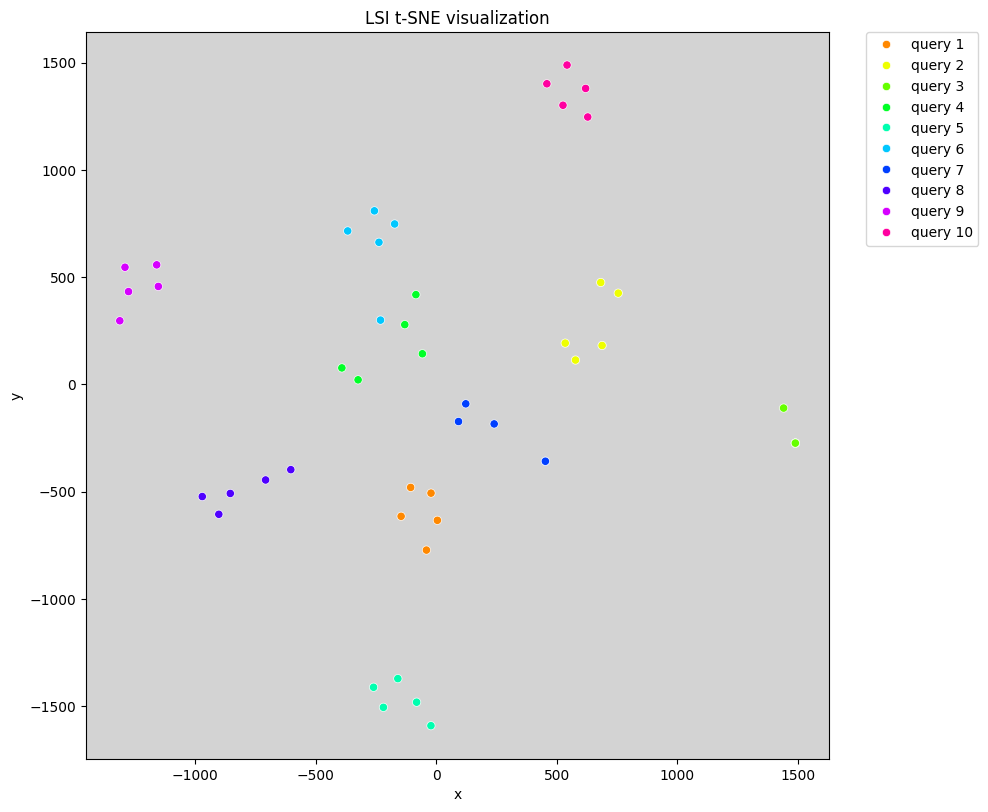

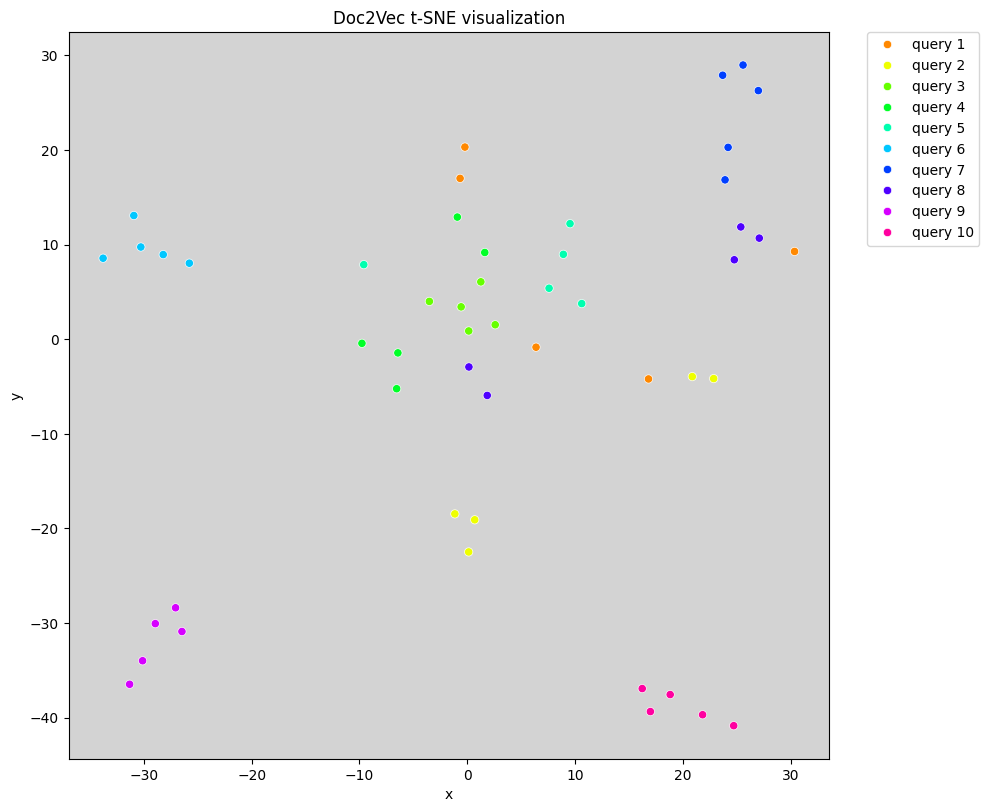

In [15]:
plot_tsne(emb_vecs['lsi'], 'LSI ')
plot_tsne(emb_vecs['d2v'], 'Doc2Vec ')